# Spotify Datasets Exploration

This notebook combines every playlist export under `data/`, applies optional cleaning steps (duplicate removal, filtering rows missing key audio features, and dropping administrative columns), and then explores the aggregated listening data.

In [1]:
from pathlib import Path
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", None)

In [2]:
data_dir = Path("data")
combined_path = data_dir / "combined_spotify_tracks.csv"

csv_files = [
    path
    for path in sorted(data_dir.rglob("*.csv"))
    if path.name != combined_path.name
]

print(f"Found {len(csv_files)} source CSV files")
if csv_files:
    print("Example paths:")
    for path in csv_files[:5]:
        print(f"  - {path}")


Found 1308 source CSV files
Example paths:
  - data/Archive/90's_and_00's_Cool_Stuff.csv
  - data/Archive/ALL_TRAVIS_SCOTT_SONGS_+_BEST_FEATURES_🔥🪐_(updated_daily).csv
  - data/Archive/All_At_Once.csv
  - data/Archive/Another_playlist_that_will_probably_spiral_out_of_control_from_adding_songs_.csv
  - data/Archive/BEST_HITS_2025_🔥_Popular_Songs_🎵_Top_Music_Hits_🎵_.csv


In [3]:
skipped_files = []


def load_all_csv(files):
    frames = []
    for path in files:
        df = None
        try:
            df = pd.read_csv(path, encoding="utf-8-sig")
        except pd.errors.ParserError as err:
            print(f"ParserError in {path.name}: {err}. Retrying with python engine and skipping bad lines.")
            try:
                df = pd.read_csv(
                    path,
                    encoding="utf-8-sig",
                    engine="python",
                    on_bad_lines="skip"
                )
            except Exception as fallback_err:
                print(f"  Fallback failed for {path.name}: {fallback_err}")
        except UnicodeDecodeError as err:
            print(f"UnicodeDecodeError in {path.name}: {err}. Retrying with latin-1 encoding.")
            try:
                df = pd.read_csv(
                    path,
                    encoding="latin-1",
                    engine="python",
                    on_bad_lines="skip"
                )
            except Exception as fallback_err:
                print(f"  Fallback failed for {path.name}: {fallback_err}")
        if df is None:
            skipped_files.append(path)
            continue
        df["source_file"] = path.name
        df["source_folder"] = path.parent.name
        frames.append(df)

    if skipped_files:
        print(f"Skipped {len(skipped_files)} files due to persistent read errors:")
        for path in skipped_files:
            print(f"  - {path}")

    if not frames:
        raise ValueError("No CSV files were successfully loaded.")

    return pd.concat(frames, ignore_index=True)


REBUILD_FROM_SOURCES = True  # Set False to load the cached combined CSV instead

if combined_path.exists() and not REBUILD_FROM_SOURCES:
    combined = pd.read_csv(combined_path)
    print(f"Loaded cached combined dataset with {combined.shape[0]:,} rows")
else:
    combined = load_all_csv(csv_files)
    print(f"Built combined dataset with {combined.shape[0]:,} rows from source CSVs")


ParserError in The_10000.csv: Error tokenizing data. C error: Expected 24 fields in line 1676, saw 35
. Retrying with python engine and skipping bad lines.
Built combined dataset with 887,584 rows from source CSVs


In [4]:
DROP_DUPLICATE_TRACKS = True
DROP_ROWS_MISSING_FEATURES = True
REQUIRED_FEATURE_COLUMNS = [
    "Loudness",
    "Mode",
    "Acousticness",
    "Energy",
    "Key",
    "Danceability",
    "Track Name",
    "Album Name",
    "Artist Name(s)"
]
COLUMNS_TO_DROP = ["Added By", "source_file", "source_folder", "Source_file", "Source_folder"]
SAVE_CLEAN_DATA = True

combined_raw = combined.copy()

numeric_columns = [
    "Duration (ms)",
    "Popularity",
    "Danceability",
    "Energy",
    "Key",
    "Loudness",
    "Mode",
    "Speechiness",
    "Acousticness",
    "Instrumentalness",
    "Liveness",
    "Valence",
    "Tempo",
    "Time Signature",
]
for column in numeric_columns:
    if column in combined.columns:
        combined[column] = pd.to_numeric(combined[column], errors="coerce")

for column in ["Release Date", "Added At"]:
    if column in combined.columns:
        combined[column] = pd.to_datetime(combined[column], errors="coerce")

cleaning_report = {}

if DROP_DUPLICATE_TRACKS and "Track URI" in combined.columns:
    before = len(combined)
    combined = combined.drop_duplicates(subset=["Track URI"])
    cleaning_report["duplicates_removed"] = before - len(combined)
else:
    cleaning_report["duplicates_removed"] = 0

if DROP_ROWS_MISSING_FEATURES:
    existing = [col for col in REQUIRED_FEATURE_COLUMNS if col in combined.columns]
    if existing:
        missing_mask = combined[existing].isna().any(axis=1)
        cleaning_report["rows_missing_features"] = int(missing_mask.sum())
        combined = combined.loc[~missing_mask].copy()
    else:
        cleaning_report["rows_missing_features"] = 0
else:
    cleaning_report["rows_missing_features"] = 0

columns_removed = [col for col in COLUMNS_TO_DROP if col in combined.columns]
if columns_removed:
    combined = combined.drop(columns=columns_removed)
cleaning_report["columns_removed"] = columns_removed

if "Release Date" in combined.columns:
    combined["Release Year"] = combined["Release Date"].dt.year

if SAVE_CLEAN_DATA:
    combined.to_csv(combined_path, index=False)
    print(f"Saved cleaned dataset to {combined_path}")

print("Cleaning summary:")
for key, value in cleaning_report.items():
    print(f"  {key}: {value}")


Saved cleaned dataset to data/combined_spotify_tracks.csv
Cleaning summary:
  duplicates_removed: 324349
  rows_missing_features: 5922
  columns_removed: ['Added By', 'source_file', 'source_folder']


In [5]:
n_rows, n_cols = combined.shape
release_min = combined["Release Date"].min() if "Release Date" in combined.columns else pd.NaT
release_max = combined["Release Date"].max() if "Release Date" in combined.columns else pd.NaT

print(f"Rows: {n_rows:,}")
print(f"Columns: {n_cols}")
if "Track URI" in combined.columns:
    print(f"Unique tracks: {combined['Track URI'].nunique():,}")
if "Artist Name(s)" in combined.columns:
    print(f"Unique artists: {combined['Artist Name(s)'].nunique():,}")
if pd.notnull(release_min) and pd.notnull(release_max):
    print(f"Release date range: {release_min.date()} → {release_max.date()}")
else:
    print("Release date range: unavailable")


Rows: 557,313
Columns: 24
Unique tracks: 557,313
Unique artists: 170,000
Release date range: 1900-01-01 → 2025-10-13


In [6]:
missing = combined.isna().sum().sort_values(ascending=False)
missing = missing[missing > 0]
missing_summary = (
    missing.to_frame(name="missing_count")
    .assign(missing_pct=lambda frame: frame["missing_count"] / len(combined) * 100)
)
missing_summary.head(10)


,missing_count,missing_pct
Genres,149956,26.906963
Release Date,48981,8.788778
Release Year,48981,8.788778
Record Label,490,0.087922


In [7]:
feature_columns = [
    "Danceability",
    "Energy",
    "Loudness",
    "Speechiness",
    "Acousticness",
    "Instrumentalness",
    "Liveness",
    "Valence",
    "Tempo",
]
available_features = [c for c in feature_columns if c in combined.columns]
combined[available_features].describe().T


,count,mean,std,min,25%,50%,75%,max
Danceability,557313.0,0.559751,0.180877,0.0,0.437000,0.57100,0.6960,0.995
Energy,557313.0,0.641908,0.243809,0.0,0.476000,0.67700,0.8470,1.000
Loudness,557313.0,-8.694059,4.660401,-60.0,-10.828000,-7.68400,-5.4930,5.773
Speechiness,557313.0,0.089374,0.095793,0.0,0.036200,0.05040,0.0946,0.968
Acousticness,557313.0,0.271496,0.318584,0.0,0.010200,0.11300,0.4850,0.996
Instrumentalness,557313.0,0.201512,0.331735,0.0,0.000001,0.00106,0.2980,1.000
Liveness,557313.0,0.199606,0.167067,0.0,0.097000,0.13000,0.2590,1.000
Valence,557313.0,0.481811,0.258543,0.0,0.270000,0.47700,0.6890,1.000
Tempo,557313.0,121.998913,29.019487,0.0,99.994000,120.20700,139.9970,247.936


In [8]:
if "Genres" in combined.columns:
    genre_counter = Counter()
    for entry in combined["Genres"].dropna():
        values = [genre.strip() for genre in str(entry).split(',') if genre.strip()]
        genre_counter.update(values)

    unique_genres = len(genre_counter)
    print(f"Unique genre tags: {unique_genres:,}")
    top_genres = pd.DataFrame(genre_counter.most_common(15), columns=["Genre", "Count"])
    display(top_genres)
else:
    print("No Genres column available for analysis.")


Unique genre tags: 737


,Genre,Count
0,metal,14409
1,post-punk,13509
2,jazz,12523
3,celtic,11596
4,rock,10951
5,punk,10937
6,classic rock,9868
7,darkwave,9358
8,anime,8695
9,new wave,8674


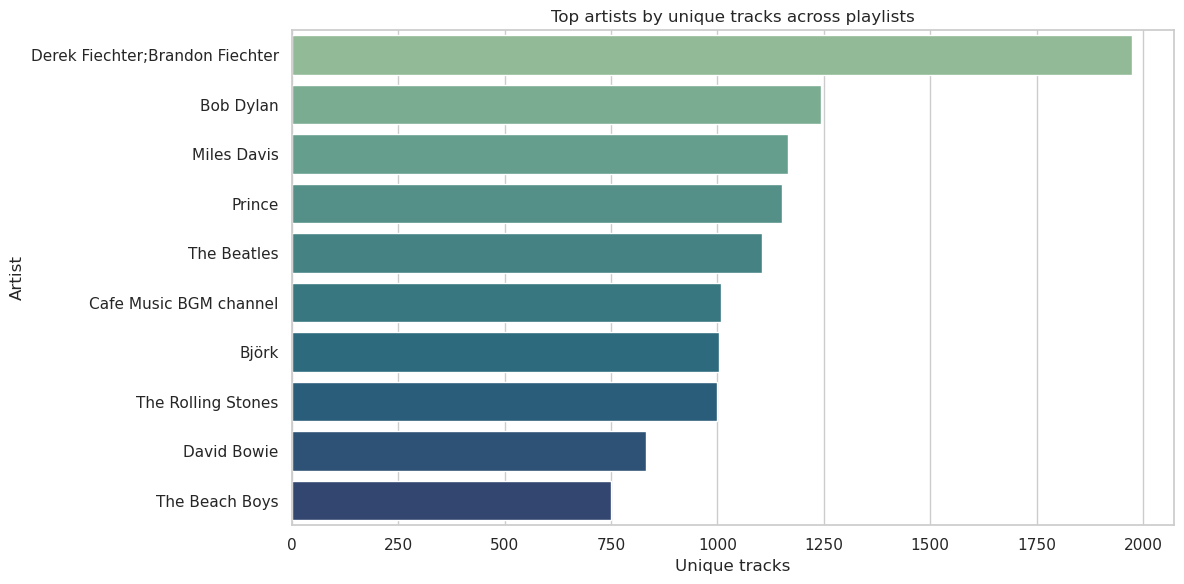

In [9]:
top_artists = (
    combined.groupby("Artist Name(s)")["Track URI"].nunique()
    .sort_values(ascending=False)
    .head(10)
    .reset_index(name="unique_tracks")
)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_artists, x="unique_tracks", y="Artist Name(s)", palette="crest")
plt.title("Top artists by unique tracks across playlists")
plt.xlabel("Unique tracks")
plt.ylabel("Artist")
plt.tight_layout()
plt.show()


In [10]:
if "Track URI" in combined_raw.columns and "source_file" in combined_raw.columns:
    overlap_base = combined_raw.copy()
    if "Track URI" in combined.columns:
        overlap_base = overlap_base[overlap_base["Track URI"].isin(combined["Track URI"])]

    track_overlap = (
        overlap_base.groupby("Track URI")
        .agg(
            track_name=("Track Name", "first"),
            artist=("Artist Name(s)", "first"),
            playlists=("source_file", "nunique"),
            appearances=("Track URI", "size"),
        )
        .query("playlists > 1")
        .sort_values("appearances", ascending=False)
        .head(10)
    )
    track_overlap
else:
    print("Track overlap analysis unavailable because source columns were removed.")


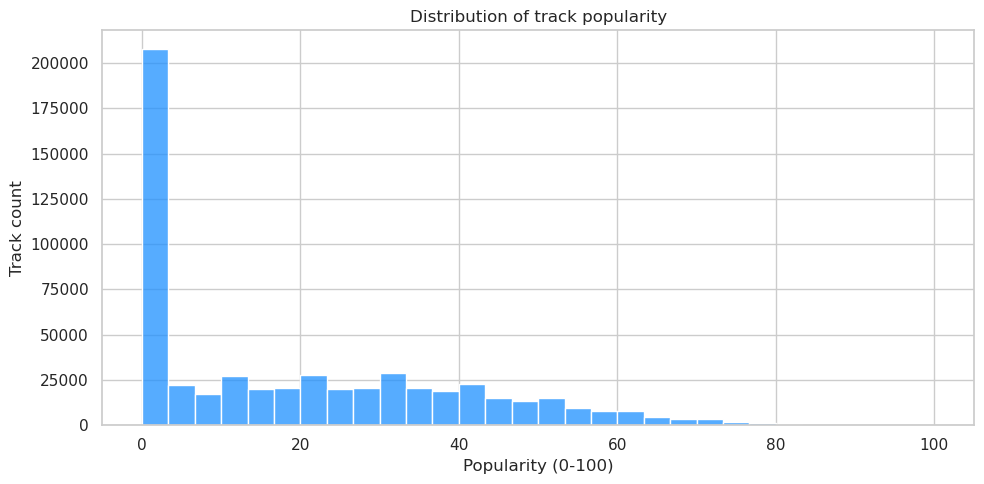

In [11]:
plt.figure(figsize=(10, 5))
sns.histplot(data=combined, x="Popularity", bins=30, kde=False, color="dodgerblue")
plt.title("Distribution of track popularity")
plt.xlabel("Popularity (0-100)")
plt.ylabel("Track count")
plt.tight_layout()
plt.show()


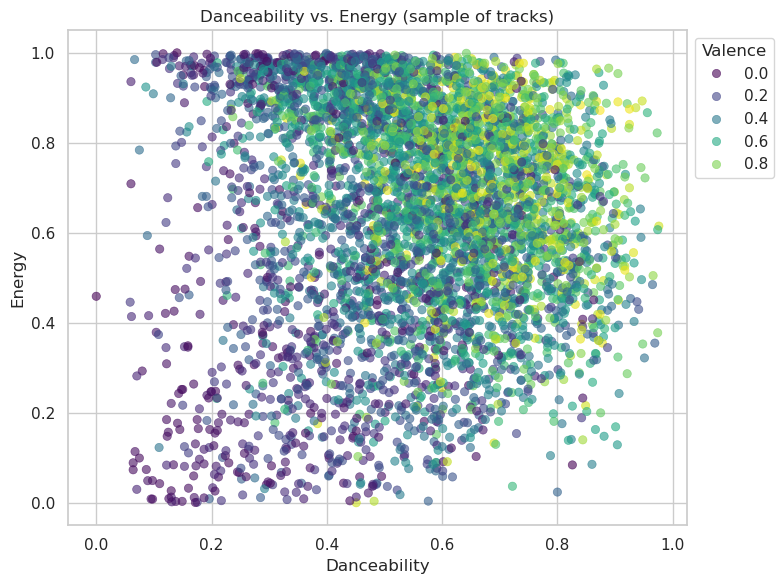

In [12]:
scatter_sample = combined.dropna(subset=["Danceability", "Energy"])
if len(scatter_sample) > 5000:
    scatter_sample = scatter_sample.sample(5000, random_state=42)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=scatter_sample,
    x="Danceability",
    y="Energy",
    hue="Valence" if "Valence" in scatter_sample.columns else None,
    palette="viridis",
    alpha=0.6,
    edgecolor=None,
)
plt.title("Danceability vs. Energy (sample of tracks)")
plt.xlabel("Danceability")
plt.ylabel("Energy")
if "Valence" in scatter_sample.columns:
    plt.legend(title="Valence", loc="upper left", bbox_to_anchor=(1, 1))
else:
    plt.legend().remove()
plt.tight_layout()
plt.show()


In [13]:
if "source_file" in combined_raw.columns:
    playlist_summary = (
        combined_raw.groupby("source_file")
        .agg(
            unique_tracks=("Track URI", "nunique"),
            avg_popularity=("Popularity", "mean"),
            avg_danceability=("Danceability", "mean"),
            avg_energy=("Energy", "mean"),
        )
        .sort_values("unique_tracks", ascending=False)
        .head(10)
    )
    playlist_summary
else:
    print("Playlist-level summary unavailable because source columns were removed.")


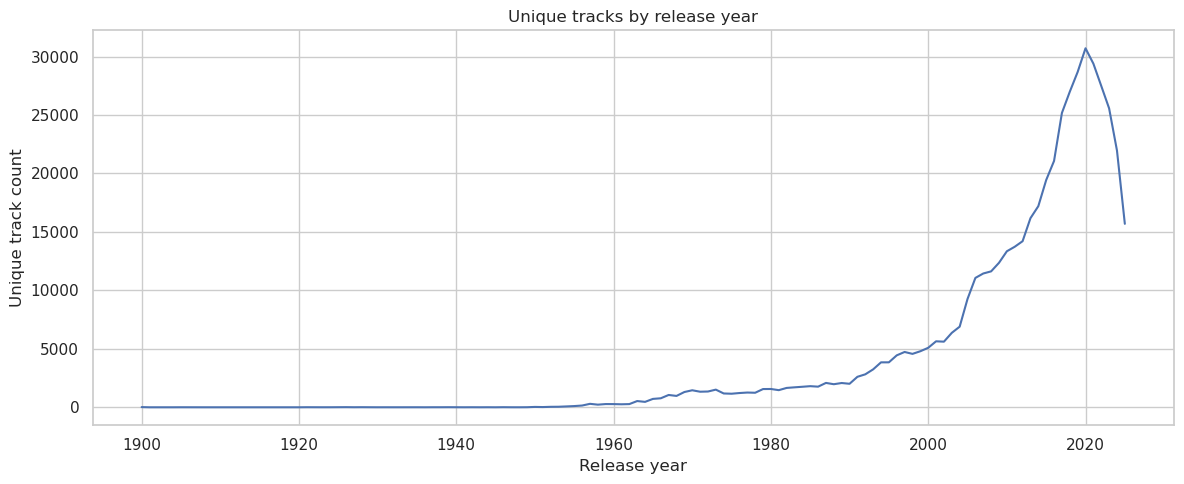

In [14]:
if "Release Year" in combined.columns:
    yearly_release = (
        combined.dropna(subset=["Release Year"])
        .groupby("Release Year")["Track URI"].nunique()
        .reset_index(name="unique_tracks")
    )

    plt.figure(figsize=(12, 5))
    sns.lineplot(data=yearly_release, x="Release Year", y="unique_tracks")
    plt.title("Unique tracks by release year")
    plt.xlabel("Release year")
    plt.ylabel("Unique track count")
    plt.tight_layout()
    plt.show()
else:
    print("Release year column unavailable.")


In [15]:
if "Popularity" in combined.columns:
    zero_popularity = combined[combined['Popularity'].fillna(0) == 0].copy()
    print(f'Songs with zero popularity: {zero_popularity.shape[0]:,}')
    display_columns = [col for col in ['Track Name', 'Artist Name(s)', 'Album Name', 'Release Date'] if col in zero_popularity.columns]
    if display_columns:
        display(zero_popularity[display_columns].head(15))
else:
    print('Popularity column missing from dataset.')


Songs with zero popularity: 171,916


,Track Name,Artist Name(s),Album Name,Release Date
62,Brick Shithouse,Placebo,Without You I'm Nothing,1998-10-12
63,You Don't Care About Us,Placebo,Without You I'm Nothing,1998-10-12
64,Ask for Answers,Placebo,Without You I'm Nothing,1998-10-12
65,Without You I'm Nothing,Placebo,Without You I'm Nothing,1998-10-12
66,Allergic (To Thoughts of Mother Earth),Placebo,Without You I'm Nothing,1998-10-12
67,The Crawl,Placebo,Without You I'm Nothing,1998-10-12
69,My Sweet Prince,Placebo,Without You I'm Nothing,1998-10-12
70,Summer's Gone,Placebo,Without You I'm Nothing,1998-10-12
71,Scared of Girls,Placebo,Without You I'm Nothing,1998-10-12
72,Burger Queen,Placebo,Without You I'm Nothing,1998-10-12


In [16]:
EXPORT_PATH = Path("data/combined_spotify_tracks.csv")
combined.to_csv(EXPORT_PATH, index=False)
print(f"Updated dataset written to {EXPORT_PATH} ({combined.shape[0]:,} rows).")

Updated dataset written to data/combined_spotify_tracks.csv (557,313 rows).
